# Student Performance Prediction
this notebook predicts the performance of a student based on dataset

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.regression.linear_model import OLS
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy import stats
from sklearn.metrics import r2_score
from scipy.stats import jarque_bera, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import itertools
import requests
import zipfile
import os
import io
import base64
from io import BytesIO
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'

response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
math_df = pd.read_csv(z.open('student-mat.csv'), sep=';')
port_df = pd.read_csv(z.open('student-por.csv'), sep=';')

math_df['subject'] = 'math'
port_df['subject'] = 'portuguese'
df = pd.concat([math_df, port_df], ignore_index=True)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target variable (G3) statistics:")
print(df['G3'].describe())

Dataset shape: (1044, 34)
Missing values: 0
Target variable (G3) statistics:
count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64


# Data Exploration

Data Types:
object    18
int64     16
Name: count, dtype: int64

Unique values in categorical columns:
school: 2 unique values
sex: 2 unique values
address: 2 unique values
famsize: 2 unique values
Pstatus: 2 unique values
Mjob: 5 unique values
Fjob: 5 unique values
reason: 4 unique values
guardian: 3 unique values
schoolsup: 2 unique values
famsup: 2 unique values
paid: 2 unique values
activities: 2 unique values
nursery: 2 unique values
higher: 2 unique values
internet: 2 unique values
romantic: 2 unique values
subject: 2 unique values


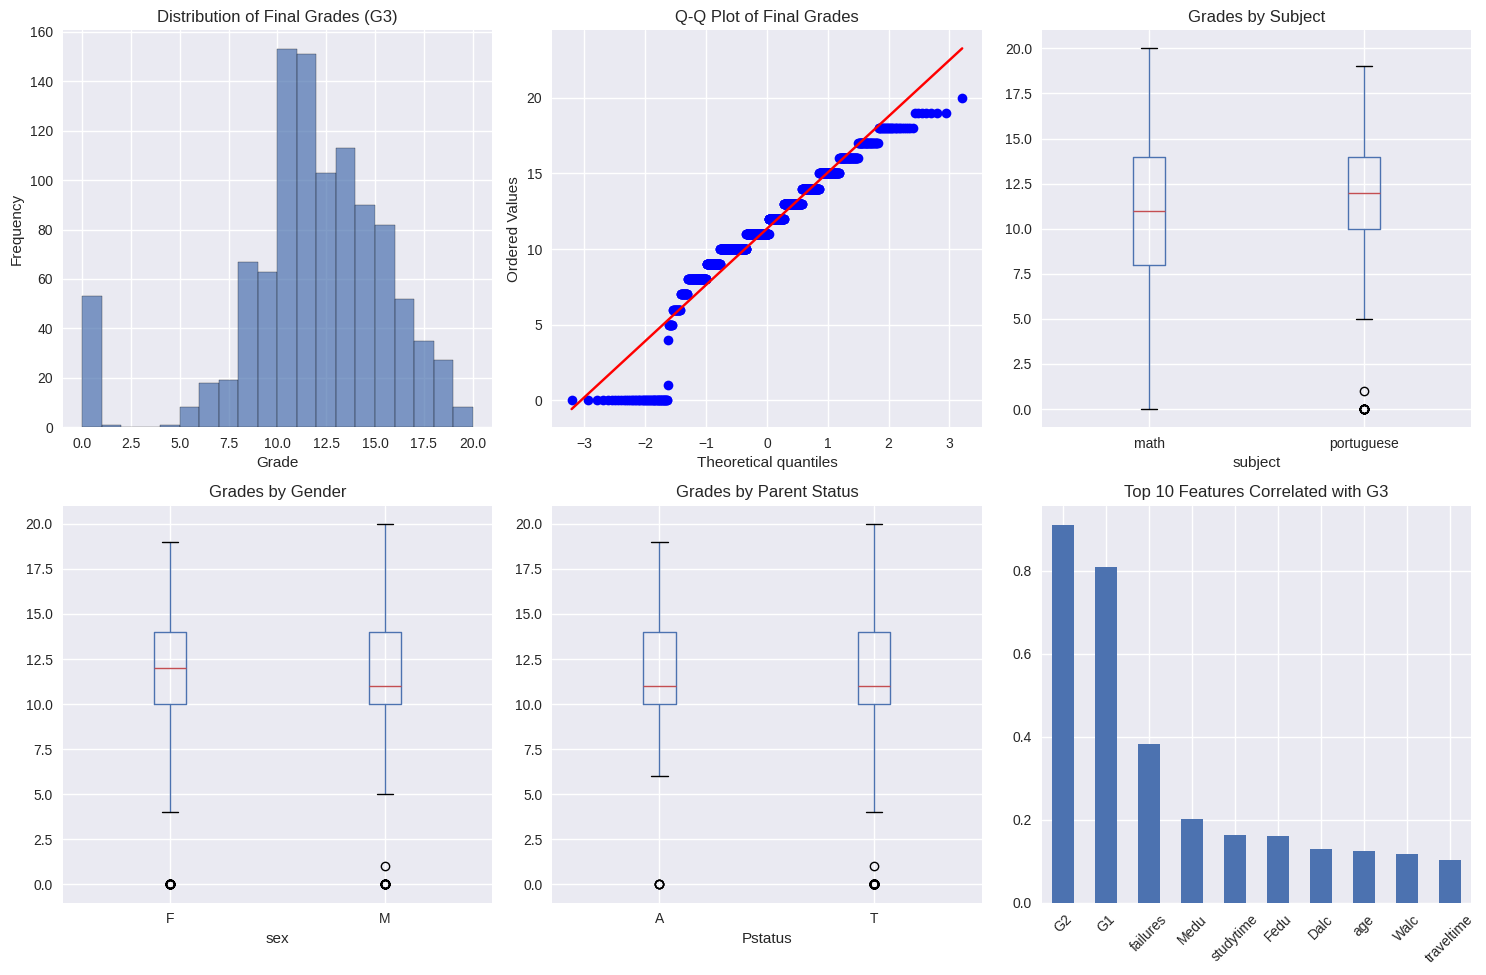

In [3]:
print("Data Types:")
print(df.dtypes.value_counts())
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.hist(df['G3'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Grades (G3)')
plt.xlabel('Grade')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
stats.probplot(df['G3'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Final Grades')

plt.subplot(2, 3, 3)
df.boxplot(column='G3', by='subject', ax=plt.gca())
plt.title('Grades by Subject')
plt.suptitle('')

plt.subplot(2, 3, 4)
df.boxplot(column='G3', by='sex', ax=plt.gca())
plt.title('Grades by Gender')
plt.suptitle('')

plt.subplot(2, 3, 5)
df.boxplot(column='G3', by='Pstatus', ax=plt.gca())
plt.title('Grades by Parent Status')
plt.suptitle('')

plt.subplot(2, 3, 6)
numerical_df = df.select_dtypes(include=[np.number])
correlation_with_target = numerical_df.corr()['G3'].abs().sort_values(ascending=False)[1:11]
correlation_with_target.plot(kind='bar')
plt.title('Top 10 Features Correlated with G3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical Tests and Distribution Analysis

In [4]:
jb_stat, jb_pvalue = jarque_bera(df['G3'])
shapiro_stat, shapiro_pvalue = stats.shapiro(df['G3'])
ks_stat, ks_pvalue = stats.kstest(df['G3'], 'norm', args=(df['G3'].mean(), df['G3'].std()))

print("Normality Tests for Target Variable (G3):")
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_pvalue:.4f}")
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

print("\nStatistical Tests Between Groups:")
male_grades = df[df['sex'] == 'M']['G3']
female_grades = df[df['sex'] == 'F']['G3']
t_stat, t_pvalue = stats.ttest_ind(male_grades, female_grades)
print(f"T-test (Male vs Female): t-statistic={t_stat:.4f}, p-value={t_pvalue:.4f}")

urban_grades = df[df['address'] == 'U']['G3']
rural_grades = df[df['address'] == 'R']['G3']
u_stat, u_pvalue = stats.mannwhitneyu(urban_grades, rural_grades)
print(f"Mann-Whitney U test (Urban vs Rural): U-statistic={u_stat:.4f}, p-value={u_pvalue:.4f}")

school_groups = [group['G3'].values for name, group in df.groupby('school')]
f_stat, f_pvalue = stats.f_oneway(*school_groups)
print(f"ANOVA (Schools): F-statistic={f_stat:.4f}, p-value={f_pvalue:.4f}")

Normality Tests for Target Variable (G3):
Jarque-Bera test: statistic=298.8906, p-value=0.0000
Shapiro-Wilk test: statistic=0.9183, p-value=0.0000
Kolmogorov-Smirnov test: statistic=0.1439, p-value=0.0000

Statistical Tests Between Groups:
T-test (Male vs Female): t-statistic=-1.0164, p-value=0.3097
Mann-Whitney U test (Urban vs Rural): U-statistic=126790.0000, p-value=0.0000
ANOVA (Schools): F-statistic=17.1131, p-value=0.0000


# Correlation and Relationship Analysis

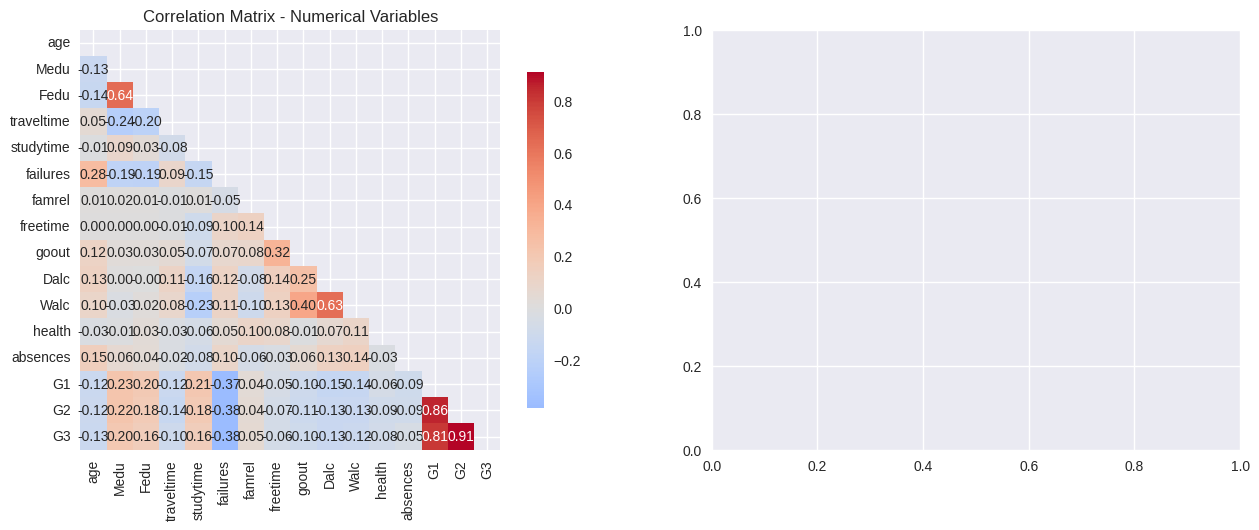

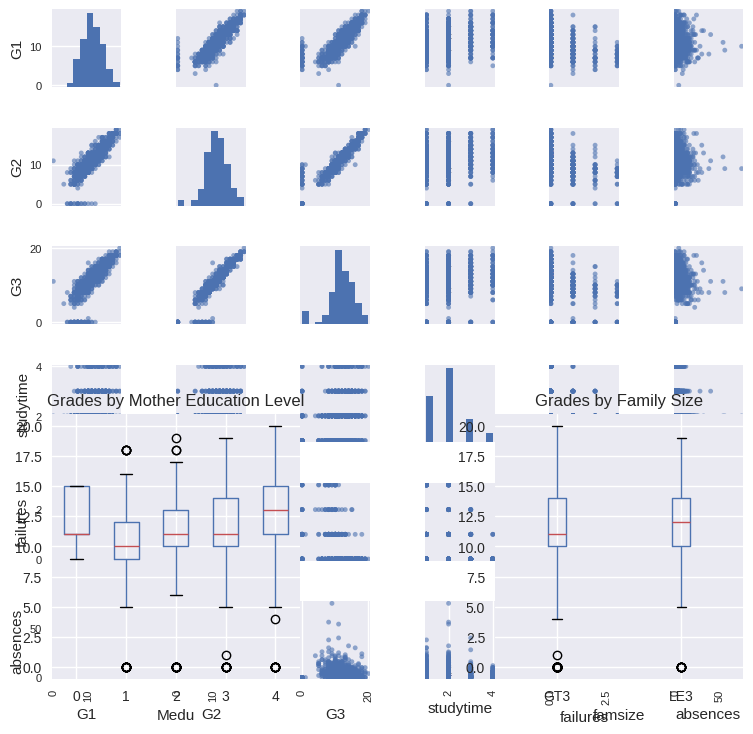

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Variables')

key_vars = ['G1', 'G2', 'G3', 'studytime', 'failures', 'absences']
plt.subplot(2, 2, 2)
pd.plotting.scatter_matrix(df[key_vars], alpha=0.6, figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatter Plot Matrix - Key Variables')

plt.subplot(2, 2, 3)
df.boxplot(column='G3', by='Medu', ax=plt.gca())
plt.title('Grades by Mother Education Level')
plt.suptitle('')

plt.subplot(2, 2, 4)
df.boxplot(column='G3', by='famsize', ax=plt.gca())
plt.title('Grades by Family Size')
plt.suptitle('')

plt.tight_layout()
plt.show()